# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape:   ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:       ', X_test.shape)
print('Test labels shape:     ', y_test.shape)

Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


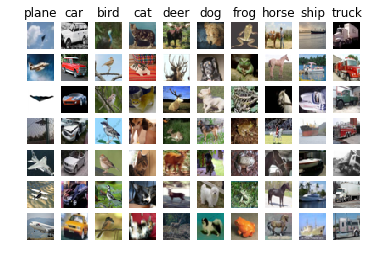

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [6]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


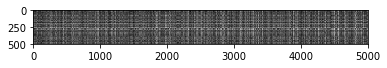

In [7]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$

-  1. The bright rows are training images that are very similar in RGB value to lots of the test images.  I'd guess it's because of a lot of the images have a lot of black or white pixels in the same locations (ie. background pixels).  Say there are a lot of pictures taken outdoors in the daytime; light blue pixels ought to be at the top of plenty of the 32x32 images
-  2. The bright columns are test images that are similar in RGB value (in particular locations, also) to many different training images.  I realized it might not just be the sky; if there are lots of images with green grass along the bottom, they will all be classified as "the same" by the KNN classifier.  

-  KNN is a pretty terrible way to classify images.  We care about the foreground, not the background.  And if there's a black dog in the training data and a white dog in the test data, but if the black dog "Spot" is outdoors in the picture and the white dog "Fido" is indoors in its picture (ie. with very different colored background pixels at every location), Fido will not be classified as a dog.  So probably this is the point of the question; to let me (ie. any student) understand why simple KNN doesn't work for classification

In [8]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$

1, 2, 3, and 5

$\color{blue}{\textit Your Explanation:}$

For these answers, I use the following notation:

1. $\mu_g$ for global mean, 

2. $\sigma_g$ for global standard deviation,

3. $\mu_{pix}$ for pixelwise mean,

4. $\sigma_{pix}$ for pixelwise standard deviation

=======================

1. For question number 1, the means just cancel out; ie: $$\sum_{P \in pixels}|I_1^P - \mu_g - (I_2^P - \mu_g)|  = \sum_{P \in pixels}|I_1^P - \mu_g +\mu_g - I_2^P)|$$ wherein the $\mu_g$ terms cancel, giving us $\sum_{P \in pixels}|I_1^P - I_2^P|$.  This value $|I_1^P - I_2^P|$ is the same as in the original L1 norm error, so the performance of our NearestNeighbor classifier using L1 distance is that same as it was originally.

2. For question number 2, the means also cancel out like in question 1.  ie: $\sum_{P \in pixels}|I_1^P - \mu_{P} - (I_2^P - \mu_P)|  = \sum_{P \in pixels}|I_1^P - \mu_P +\mu_P - I_2^P)|$ wherein the $\mu_P$ terms cancel, giving us $\sum_{P \in pixels}|I_1^P - I_2^P|$.  Again, this value $|I_1^P - I_2^P|$ is the same as in the original L1 norm error, so the performance of our NearestNeighbor classifier using L1 distance is that same as it was originally.

3.  For question number 3, the standard deviation is **global** ($\sigma_g$).  In other words, although the computation has many terms:$$\sigma_g=\sqrt{\frac{1}{3nhw}\sum_{RGB=1}^3\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w} (p_{ij}^{(k)}-\mu_g)^2 }$$, we end up with a simple result at the end where we can factor out $\sigma_g$:  $$\sum_{P \in pixels} | \frac{I_1^P - \mu_g}{\sigma_g}  - \frac{I_2^P - \mu_g}{\sigma_g}| = \sum_{P \in pixels} | \frac{I_1^P - I_2^P}{\sigma_g}|$$ and then we know $\sigma_g \ge 0$ because $\sigma_g = \sqrt{...}$ so we can move the $\sigma_g$ outside the norm like so: $$\frac{1}{\sigma_g}\sum_{P \in pixels} | I_1^P - I_2^P|$$ and we get an answer that is 100% proportional to our original NearestNeighbor's L1 distance, so the performance of our NearestNeighbor classifier is the same as before the preprocssing.

4. ___This is the only case where the performance changes.___  Dividing by the pixel-wise standard deviation is the only operation that will change the classification because it changes the *relative* values of each pixel-difference.  Mathematically, $$\sigma_{ij} = \sqrt{\frac{1}{3nhw} \sum_{RGB=1}^3 \sum_{k=1}^n (p_{ij}^{(k)}-\mu_{ij})^2 }$$ and $$\sum_{P \in pixels} | \frac{I_1^P - \mu_{ij}}{\sigma_{ij}}  - \frac{I_2^P - \mu_{ij}}{\sigma_{ij}}| = \sum_{P \in pixels} | \frac{I_1^P - I_2^P}{\sigma_{ij}}|$$ but because the $\sigma_{ij}$ is dependent on the indices $i$ and $j$, we can't pull the fraction out front.  In English, what this basically means is we've told the NearestNeighbor classifier which pixels are more important; if the variation $\sigma_{ij}$ has a low value on the "ij-th" pixel, that pixel has been declared "more important."  Unfortunately this is not the type of learning we care about, because individual pixel's levels RGB variation have little semantic value; we can't declare definitively "cat" or "dog" based on pixel 33.

Another way to explain it that uses a real image as an example:  In English: consider "sky" pixels, all approximately the same value in the "B" of RGB.  If $\sigma_{sky}$ is small, even a modest change of 10 (out of 256) in the B(lue) value will change that particular L1 difference a lot.  Versus if we consider a pixel near the center of the images where the color varies more, the $\sigma_{center}$ will be quite large, so the term $\frac{I_1^P - I_2^P}{\sigma_{ij}}$ will be pretty small, even if $I_1^P - I_2^P$ is large (ie. near 256)

5.  Rotating the images doesn't change the differences that go into the L1 norm, at least so long as every image is rotated identically.  And to make sure I addressed the literal question posed, "rotating coordinate axes" is the same as "rotating the images."

In [10]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

# 2 and 1 loop are too slow
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 39.750665 seconds
One loop version took 289.380282 seconds
No loop version took 0.627893 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [13]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
Y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint:Look up the numpy "array_split" function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

n_folds=num_folds
Y_train=y_train
X_train_folds=np.array_split(X_train, n_folds)  # debug these lines
Y_train_folds=np.array_split(Y_train, n_folds)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for k in k_choices:
    accuracies=[]

    # try k on each validation fold
    for val_i in range(n_folds):
        # make validation
        X_val=X_train_folds[val_i]
        Y_val=Y_train_folds[val_i]
        n_val = Y_val.shape[0]

        # make train_curr: (current fold's training data)
        fold_size     = Y_train_folds[0].shape[0]
        end_1st       = val_i * fold_size # 1000 for val_i ==1 && fold_size == 1000
        start_2nd     = (val_i * fold_size)+fold_size # 1000 for val_i ==1 && fold_size == 1000
        X_train_curr  = np.concatenate(  (X_train[:end_1st,:], X_train[start_2nd:,:]),  axis=0)
        Y_train_curr  = np.concatenate(  (Y_train[:end_1st  ], Y_train[start_2nd:  ]),  axis=0)

        # train
        classifier=KNearestNeighbor()
        classifier.train(X_train_curr, Y_train_curr)


        # predict & calcul8 error:
        dists=classifier.compute_distances_no_loops(X_val)
        
        # predict
        Y_val_pred = classifier.predict_labels(dists, k=k)
        n_correct = np.sum(Y_val_pred == Y_val)
        accuracies.append(float(n_correct) / n_val)
    # end for loop "for val_i in range(n_folds)"
    k_to_accuracies[k] = accuracies
# end for loop "for k in k_choices":

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

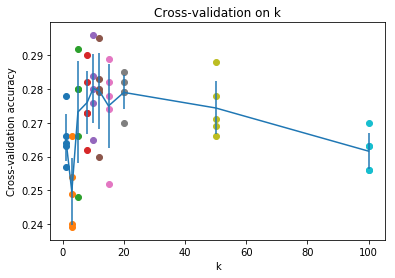

In [14]:
# plot the raw observations:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
# k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100].   So the best k (most reliably high {low variance, high mean}) is gray
#              |  |  |  |   |   |   |   |   | 
#       Dark blue |  | DRed |   |


#   1 Dark Blue
#   3 Orange
#   5 Dark Green
#   8 Dark Red
#  10 Dark Purple         k=10; DPurple; best_acc==0.28
#  12 Brown
#  15 Pink
#  20 Gray
#  50 Chartreuse
# 100 Light Blue


# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [15]:
# Based on my "careful analysis" of the above K using matplotlib.pyplot,
# it seems Cross-Validation is a waste of time AS LONG AS
# there are few hyperparameters/model settings to consider.

#   The other detail worth considering is that in this TRIVIALLY SIMPLE CASE   (KNN on CIFAR-10),
# All the KNN model does is memorize training data.  So
# all the train data is equivalent to all test data
# (because it's not a NN that would actually learn & change its own model parameters during the process of training),

#__________________________________________________________________________________________________
#
#                    Code:
#__________________________________________________________________________________________________

# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 20

for best_k in k_choices:

    # NOTE NOTE TODO:   for this case, we should just for-loop through all the hyperparameters 
    #                      (ie. values of "k" in this case)
    #
    classifier = KNearestNeighbor()
    classifier.train(X_train, y_train)
    y_test_pred = classifier.predict(X_test, k=best_k)

    # Compute and display the accuracy
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print('k=%3d.   Got %d / %d correct => accuracy: %f' % (best_k, num_correct, num_test, accuracy))

k=  1.   Got 137 / 500 correct => accuracy: 0.274000
k=  3.   Got 136 / 500 correct => accuracy: 0.272000
k=  5.   Got 139 / 500 correct => accuracy: 0.278000
k=  8.   Got 137 / 500 correct => accuracy: 0.274000
k= 10.   Got 141 / 500 correct => accuracy: 0.282000
k= 12.   Got 128 / 500 correct => accuracy: 0.256000
k= 15.   Got 136 / 500 correct => accuracy: 0.272000
k= 20.   Got 136 / 500 correct => accuracy: 0.272000
k= 50.   Got 126 / 500 correct => accuracy: 0.252000
k=100.   Got 111 / 500 correct => accuracy: 0.222000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$

Usually 4.  But it depends how big the training set is we're talking about.  For small changes in the size of the training set, ($\delta_n$ << \infty), assuming we're using the fully parallelized func "compute_distances_no_loops()," I think there is no change in time needed to classify a test example, because numpy parallelization in "compute_distances_no_loops()" makes $time_n=O(10000) \approx O(10001)$ (ie. if 2 arrays are about the same size, it shouldn't take significantly more time to allocate the extra element, or to process it)

4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Explanation:}$

To repeat the question, I'm explaining which answers are **NOT** true about $k$-Nearest Neighbor ($k$-NN) in a classification setting, and for all $k$.
1. The decision boundary of the k-NN classifier is linear.

No; to see why, just graph:
"cat" data points (-1,-100) and (-1, 100), and
"dog"  data points ( 1, 100)
with k=1 and dist='L2';
The boundary is **piecewise** linear, but not linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.

No.  The key word is "always."  Only one example of "$\exists$ a parameter setting $\theta$ such that $ err_{1-NN} \geq err_{5-NN} $ given $\theta$ is enough to say the statement is false.  This is called a "Proof by Contraposition," in formal logic (https://www.cs.sfu.ca/~ggbaker/zju/math/proof.html#contrapos); the contrapositive of the statement "The training error of a 1-NN will always be lower than that of 5-NN." is "there is **at least** 1 case (could be $> 1$) where the training error of a 5-NN is greater than or equal to that of a 1-NN" (for the same data and same other parameter settings $\theta$, such as which type of distance we're using to define "nearest").

The actual counterexample:  In simple words, we want a 5-NN classifier that does better than a 1-NN classifier.  Our 5-NN classifier in **this very notebook** is this way.  So number 2 is wrong.   Another example is below.

Let me say what we want again, because the first time I answered this question I got it backwards.  "We want a 5-NN classifier that does better than a 1-NN classifier."  In other words, **5-NN** has to do **better** than a simpler **1-NearestNeighbor** on a set of data.  Picture a number line with 6 colored dots on it.  The dots are training data.  Not 2-D Cartesian: a super simple **1-D** number line.  There's a green point at 0.  Then there are blue points at 1, 10, 11, 12, and 13.  In training for both 1-NN and 5-NN, the green point gets called "blue;" error.  But in 1-NN, the blue point at 1 gets labeled "green," (an **error**) whereas in 5-NN that blue point at 1 is **correctly** labeled "blue."  So 5-NN does better than simple 1-NN, and the statement for question 2 ("The training error of a 1-NN will always be lower than that of 5-NN.") is **False**.  




3. The test error of a 1-NN will always be lower than that of a 5-NN.

No.  See the 1st detailed paragraph-answer to question 2. for "formal-logic-reasons-why;"  my counterexample here is the same as in question 2; the 1-NN and 5-NN in this iPython notebook.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.




our 5-NN image classifier did better .  Consider a dataset where there are data points for cats and data points for dogs.  All the cats and dogs in the training data are twins with identical weight and average (ie. mean, not median or mode) fur color.  So the nearest neighbor (1-NN) **always** classifies correctly.  But then consider a very light (ie. low mass) pair of Dachsund twins and 2 pairs of twins (4 Havana Brown cats) with extremely similar average color and weight to the Dachsund twins.  A Dachsund is a "wiener dog;" typically brown in color, long-bodied, and with very short legs.  All other dogs in the training data are much heavier than the tiny Dachsunds.  tiny dataset: 6 data points, all labeled "cat"; both 1-NN and 5-NN are equally perfect (ie. the statement "$err_{1-NN} < err_{5-NN} \forall$ parameter settings" is false b/c one counterexample is enough to disprove).

Images of our feline and canine friends are in the cells below:


![KNN_line_example](https://neonb88.files.wordpress.com/2019/06/cs231n_2019___assn_1____inline_question_3____knn_answer__.png)

# Images of our feline and canine friends from question 3:

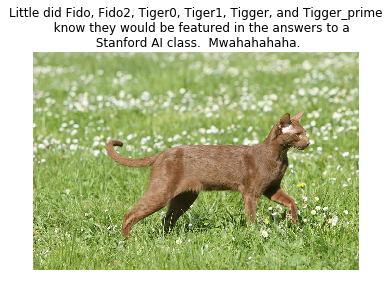

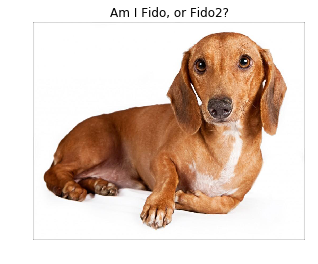

In [16]:
from PIL import Image
import requests
from io import BytesIO

#cat
cat_url="https://www.cat-breeds-encyclopedia.com/images/Havana-brown-in-field.jpg"
response = requests.get(cat_url)
cat_img = Image.open(BytesIO(response.content))

plt.axis('off')
plt.imshow(cat_img)
plt.title("Little did Fido, Fido2, Tiger0, Tiger1, Tigger, and Tigger_prime\n   know they would be featured in the answers to a\n Stanford AI class.  Mwahahahaha.")
plt.show()

#dog
dog_url="https://blog.timesunion.com/bark/files/2012/02/Dachshund.jpg"
response = requests.get(dog_url)
dog_img = Image.open(BytesIO(response.content))

plt.axis('off')
plt.imshow(dog_img)
plt.title("Am I Fido, or Fido2?")
# show
plt.show()

# Notes (Data, etc. ; not a critical part of the assignment)

In [ ]:
# So for this trivially simple case of KNN, 
#   we may as well use all the "training data" as "validation data"   and evaluate the hyperparameter 'k' based on all the data on all the other data.
#   A more sophisticated way of picking the validation "folds"
# 


# In the rare case where 1. there are many many choices to make and 2. everything can be evaluated quantitatively,
#   Cross-Validation may be worth it.

# That said, perhaps if you're not aware of the weaknesses of your model, doing Cross-Validation **might** be worth it 




# May need to shuffle the data


#  Data:
#__________________________________________________________________________________________________
#
#  k     n_correct/ 500                     acc (frac of 1; multiply by 100 to get percent correct):
#       (b/c there are 500 total
#       test images from CIFAR-10)
#__________________________________________________________________________________________________

#k=  1.   Got 137 / 500 correct => accuracy: 0.274000
#k=  3.   Got 136 / 500 correct => accuracy: 0.272000
#k=  5.   Got 139 / 500 correct => accuracy: 0.278000
#k=  8.   Got 137 / 500 correct => accuracy: 0.274000
#k= 10.   Got 141 / 500 correct => accuracy: 0.282000
#k= 12.   Got 128 / 500 correct => accuracy: 0.256000
#k= 15.   Got 136 / 500 correct => accuracy: 0.272000
#k= 20.   Got 136 / 500 correct => accuracy: 0.272000
#k= 50.   Got 126 / 500 correct => accuracy: 0.252000
#k=100.   Got 111 / 500 correct => accuracy: 0.222000



# Data:
#__________________________________________________________________________________________________
#
#  k     acc:  n_correct/500  (there are 500 total test images from CIFAR-10)
#__________________________________________________________________________________________________
#
#  1     
#  3
#  5
#  8
# 10.    28.%     141 / 500 correct => accuracy: 0.282000
# 12
# 15
# 20     27.2%    136
# 50
#100





#__________________________________________________________________________________________________
#__________________________________________________________________________________________________
#__________________________________________________________________________________________________
#__________________________________________________________________________________________________
#
#                                    Real Code:
#__________________________________________________________________________________________________
#__________________________________________________________________________________________________
#__________________________________________________________________________________________________
#__________________________________________________________________________________________________
